In [ ]:
# Import dependencies
import numpy as np
import pandas as pd
from PIL import Image
%matplotlib inline
from matplotlib import pyplot as plt

In [ ]:
# Read training and testing data from csv files
train_dataframe = pd.read_csv('../train.csv')
test_dataframe = pd.read_csv('../test.csv')

# Get all unique labels
labels = train_dataframe.label.unique()
print labels

In [ ]:
from keras.applications.resnet50 import ResNet50

# Read a base model which is pretrained on imagenet
base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet',input_shape=(32, 32, 3))

In [ ]:
# Read image data
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rescale=1./255)
train_generator=datagen.flow_from_dataframe(dataframe=train_dataframe, directory="../data/", x_col="file_name", y_col="label", class_mode="categorical", target_size=(32,32), batch_size=32)

In [ ]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

# function build a model
def finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    
    # Flatten the layer to form FC layer
    x = Flatten()(x)
    for fc in fc_layers:
        # create an FC layer to generate dropouts
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # Ouput layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    # Final model
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

# fully connected layer neurons
fc_Layers = [1024, 1024]

#dropout percentage
dropout = 0.5

# build a finetune model
finetune_model = finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=fc_Layers, 
                                      num_classes=len(labels))

In [ ]:
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 50
BATCH_SIZE = 32
num_train_images = 2503

# Compile the model with a learning rate and metrics
finetune_model.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# path to save training weights
filepath="ResNet50_model_one_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

# start training
history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=8, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)

In [ ]:
# plot a loss graph
def loss_graph(data):
    acc = data.history['acc']
    loss = data.history['loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, loss, 'r')
    plt.title('Training and Validation accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.title('Training and Validation loss')
    plt.show()

loss_graph(history)

In [ ]:
# load saved model
from keras.models import load_model
model = load_model('ResNet50_model_one_weights.h5')

In [ ]:
train_image_array = []
train_labels = []
numb=1

# Data Augmentation
for imgpath,label in zip(train_dataframe.file_name, train_dataframe.label):
    
    # read image
    img = Image.open("/home/eteamcon/Downloads/sweden-traffic-signs-classification-eng/data/"+imgpath)
    
    # resize image
    img = (img.resize((224,224), Image.ANTIALIAS))
    
    # convert image to pixels
    temp1 = np.asarray(img)/255
    
    
    # flip images according to the label
    if label == "PEDESTRIAN_CROSSING" or label == "PASS_EITHER_SIDE" or label == "GIVE_WAY":
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        temp2 = np.asarray(img).astype(np.float32)/255
        train_image_array.append(temp2)
        train_labels.append(label)
    elif label == "PRIORITY_ROAD" or label == "NO_STOPPING_NO_STANDING":
        img = img.rotate(90)
        temp2 = np.asarray(img).astype(np.float32)/255
        train_image_array.append(temp2)
        train_labels.append(label)
        
        img = img.rotate(180)
        temp2 = np.asarray(img).astype(np.float32)/255
        train_image_array.append(temp2)
        train_labels.append(label)
        
        img = img.rotate(270)
        temp2 = np.asarray(img).astype(np.float32)/255
        train_image_array.append(temp2)
        train_labels.append(label)
    elif label == "30_SIGN" or label == "100_SIGN" or label == "110_SIGN":
        img = img.transpose(Image.FLIP_TOP_BOTTOM)
        temp2 = np.asarray(img).astype(np.float32)/255
        train_image_array.append(temp2)
       
        train_labels.append(label)
    elif label == "NO_PARKING":
        temp_img = img.transpose(Image.FLIP_LEFT_RIGHT)
        img = temp_img.transpose(Image.FLIP_TOP_BOTTOM)
        temp2 = np.asarray(img).astype(np.float32)/255
        train_image_array.append(temp2)
        train_labels.append(label)
    

print "The shape of the new training dataset after Augmentation is "+ str(np.shape(train_image_array))

In [ ]:
# Encoding labels to train again on augmented data
encoded_labels = pd.get_dummies(train_labels)
encoded_labels.T.reindex(np.sort(labels)).T.fillna(0).astype(np.int32)

In [ ]:
filepath="ResNet50_augmented_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

# start training on augmented data
model.fit(np.array(train_image_array), (encoded_labels),  batch_size=32, epochs=50, callbacks=callbacks_list)

In [ ]:
from keras.preprocessing import image

# predict class labels on test dataset
class_list = np.sort(labels)
ans=[]
for i in range(len(test_dataframe.file_name)):
    test_image = image.load_img("/home/eteamcon/Downloads/sweden-traffic-signs-classification-eng/data/"+test_dataframe.file_name[i], target_size = (224, 224)) 
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image/255, axis = 0)

    val=model.predict(test_image)
    ind = np.argmax(val[0])

    ans.append(class_list[ind])
    print i
ans

In [ ]:
# write prediction to a csv file
test_dataframe = test_dataframe.assign(label=ans)
test_dataframe.to_csv("answers.csv", sep=',', index=False)
test_dataframe

# Predict on a single image

To validate the model: run the following blocks seperately
The following blocks will allow the user to load the trained model and display predictions on an image

In [11]:
# load saved model
from keras.models import load_model
import numpy as np
import pandas as pd
model = load_model('ResNet50_augmented_model.h5')
from keras.preprocessing import image
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image

train_dataframe = pd.read_csv('train.csv')
test_dataframe = pd.read_csv('test.csv')

# Get all unique labels
labels = train_dataframe.label.unique()

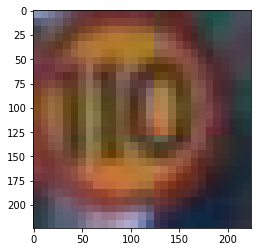

The predicted class label is: 110_SIGN


In [21]:
# choose image (i = 0 or 1 or ... 9)
i=0

test_image = image.load_img("data/"+test_dataframe.file_name[i], target_size = (224, 224)) 

# display the image
plt.figure()
plt.imshow(test_image) 
plt.show()

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image/255, axis = 0)

val=model.predict(test_image)
ind = np.argmax(val[0])
lab = np.sort(labels)[ind]
print("The predicted class label is: " + str(lab))

